In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, TimeDistributed

# Step 1: Download S&P 500 ETF (SPY) data from Yahoo Finance
data = yf.download('SPY', start='2015-12-01', end='2018-01-31')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]  # Use all features
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2015-12-01,178.530412,179.706753,178.249113,179.587402,97858400
2015-12-02,179.536265,179.860188,177.498987,177.754715,108441300
2015-12-03,178.010489,178.283256,174.532621,175.265701,166224200
2015-12-04,175.265677,178.982220,175.265677,178.683868,192913900
2015-12-07,178.351453,178.777662,176.621045,177.601334,102027100


In [2]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences for the RNN model
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]  # Use all features for the sequence
        y = data[i + seq_length, 3]  # Predict the 'Close' price (index 3)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 20  # Sequence length
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [3]:
# Sequence-to-Vector RNN Model
model_seq2vec = Sequential()
model_seq2vec.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, 5)))  # 5 features
model_seq2vec.add(Dense(1))
model_seq2vec.compile(optimizer='adam', loss='mse')

# Sequence-to-Sequence RNN Model
model_seq2seq = Sequential()
model_seq2seq.add(SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(seq_length, 5)))  # 5 features
model_seq2seq.add(TimeDistributed(Dense(1)))
model_seq2seq.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [4]:
# Train the Sequence-to-Vector model
history_seq2vec = model_seq2vec.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=1)

# Train the Sequence-to-Sequence model
history_seq2seq = model_seq2seq.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.1048 - val_loss: 0.0581
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0089 - val_loss: 0.0114
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 6.8270e-04 - val_loss: 4.8424e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.3645e-04 - val_loss: 8.7616e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8981e-04 - val_loss: 8.7559e-04
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.2148e-04 - val_loss: 8.5561e-04
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.9406e-04 - val_loss: 7.8759e-04
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.1909e-04 - val_loss: 5.9830e-04
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5342e-04 - val_loss: 5.4846e-04
Epoch 1

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
MAE for Sequence-to-Vector: 1.3241477931232246
MAE for Sequence-to-Sequence: 33.87938500827278


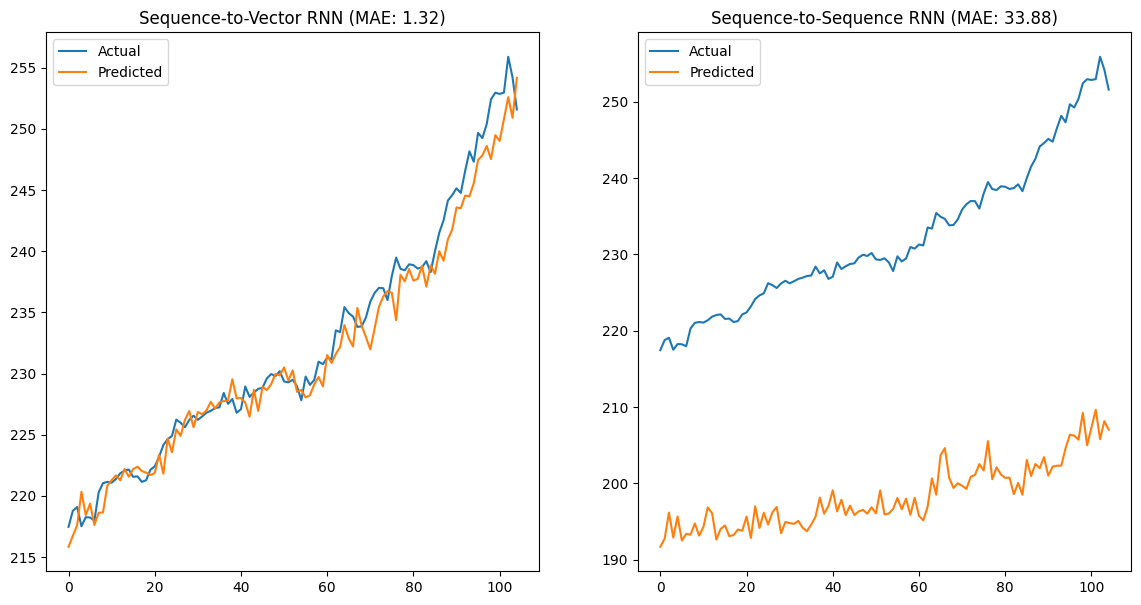

In [5]:
# Predict using the Sequence-to-Vector model
y_pred_seq2vec = model_seq2vec.predict(X_test)

# Inverse transform the predictions and actual values
# Create a dummy array to inverse transform only the 'Close' price
dummy_array_seq2vec = np.zeros((len(y_pred_seq2vec), 5))
dummy_array_seq2vec[:, 3] = y_pred_seq2vec.flatten()
y_pred_seq2vec = scaler.inverse_transform(dummy_array_seq2vec)[:, 3]

dummy_array_test = np.zeros((len(y_test), 5))
dummy_array_test[:, 3] = y_test.flatten()
y_test_actual = scaler.inverse_transform(dummy_array_test)[:, 3]

# Predict using the Sequence-to-Sequence model
y_pred_seq2seq = model_seq2seq.predict(X_test)
y_pred_seq2seq = y_pred_seq2seq[:, -1, :]  # Take the last output in the sequence

# Inverse transform the predictions
dummy_array_seq2seq = np.zeros((len(y_pred_seq2seq), 5))
dummy_array_seq2seq[:, 3] = y_pred_seq2seq.flatten()
y_pred_seq2seq = scaler.inverse_transform(dummy_array_seq2seq)[:, 3]

# Calculate MAE
mae_seq2vec = mean_absolute_error(y_test_actual, y_pred_seq2vec)
mae_seq2seq = mean_absolute_error(y_test_actual, y_pred_seq2seq)

print(f"MAE for Sequence-to-Vector: {mae_seq2vec}")
print(f"MAE for Sequence-to-Sequence: {mae_seq2seq}")

# Plot the results
plt.figure(figsize=(14, 7))

# Plot Sequence-to-Vector results
plt.subplot(1, 2, 1)
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_seq2vec, label='Predicted')
plt.title(f'Sequence-to-Vector RNN (MAE: {mae_seq2vec:.2f})')
plt.legend()

# Plot Sequence-to-Sequence results
plt.subplot(1, 2, 2)
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_seq2seq, label='Predicted')
plt.title(f'Sequence-to-Sequence RNN (MAE: {mae_seq2seq:.2f})')
plt.legend()

plt.show()